In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lesson 2

In the screencast for this lesson I go through a few scenarios for time series. This notebook contains the code for that with a few little extras! :)

# Setup

In [1]:
!pip install -U tf-nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# 그래프 그려주는 함수
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label) # 시간이 X축이고 이에 해당하는 급수가 Y
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend and Seasonality

In [3]:
def trend(time, slope=0): # 경향. 시간이 지날수록 어느 방향으로 가는가? 
    return slope * time

Let's create a time series that just trends upward:

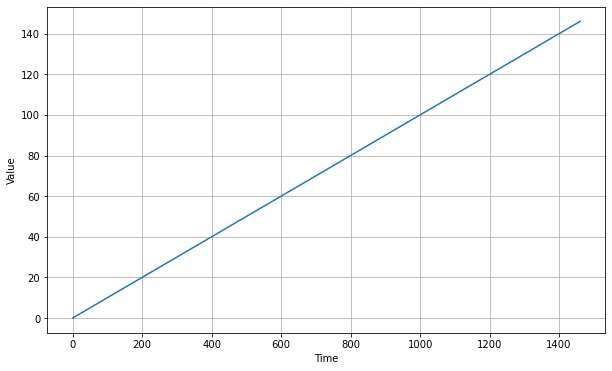

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [5]:
def seasonal_pattern(season_time): # 특정 시간 간격으로 변동 발생
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

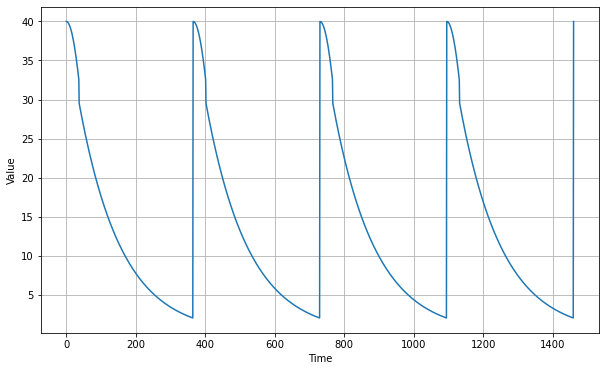

In [6]:
baseline = 5
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude) # seasonality : 일정 주기마다 같은 패턴을 반복

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

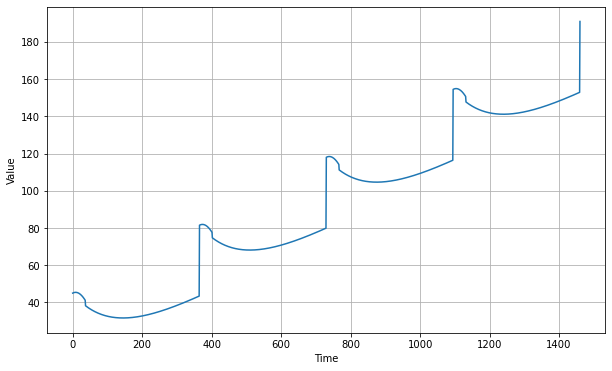

In [7]:
slope = 0.1 # 기울기가 커지면 값의 상승선? 이 커지기 때문에 변동 부분의 비중이 작게 나온다. 그렇다고 변동 크기가 작아지는건 아니다.
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) # Y값 설정

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [8]:
def white_noise(time, noise_level=1, seed=None): # 노이즈 생성
    rnd = np.random.RandomState(seed) # 난수 생성기
    return rnd.randn(len(time)) * noise_level # 난수 생성

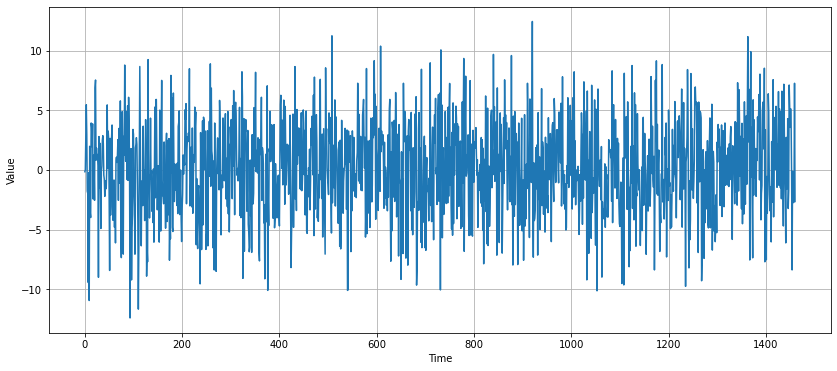

In [9]:
noise_level = 4
noise = white_noise(time, noise_level) # seed는 난수 세팅을 고정하기 위해 사용하는 변수다. 강사가 보여주는 거랑 같은 노이즈가 만들어진다는걸 확인시켜주려고 추가한듯. 

plt.figure(figsize=(14, 6)) # 그래프 크기
plot_series(time, noise) # 그래프에 난수 그리기. 보면 0을 기준으로 난수가 생성되는걸 확인할 수 있다. 
plt.show()

Now let's add this white noise to the time series:

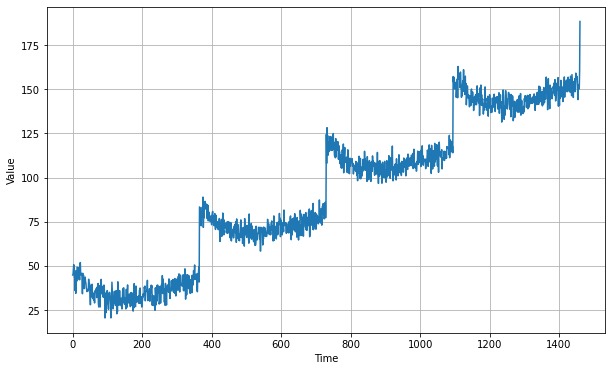

In [10]:
series += noise # 앞서 구한 Y값(일정 주기로 같은 패턴 반복 + 우상향 트랜드)에 잡음 추가

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [11]:
# 앞서 만든 그래프(트렌드 + 패턴 반복 + 노이즈)를 인덱스 1000을 기준으로 반갈(훈련셋, 검증셋)
# fixed partitioning : 데이터를 훈련셋, 검증셋, 테스트셋으로 나누는 것. 각 셋마다 온전한 반복 패턴(seasonal)이 있어야한다. 
# 하이퍼 파라미터를 조정해가며 훈련셋과 검증셋으로 훈련을 끝내고 테스트 셋으로 성능을 평가하는 순간 테스트 셋으로도 다시 재훈련할 수 있게 된다고 한다. 그래서 시계열 데이터를 만들 때는 테스트 데이터는 향후 미래에 대한 예측값으로 하고 모든 데이터셋을 훈련 셋과 검증셋으로만 쓴다.
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [12]:
def autocorrelation(time, amplitude, seed=None): # 자기상관(시간적으로 배열된 관측치의 계열의 값 사이의 내부 상관). 예를 들어 {xt} 라 할 때, xt와 xt + xt + k 사이의 상관 계수.
    # 현재의 상태가 과거와 미래의 상태에 밀접한 연관을 지니는 경우 자기상관이 있다고 한다. 
    # 얘를 사용하면 일정 패턴이 반복된다. 
    rnd = np.random.RandomState(seed) # 난수 생성
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    print(ar)
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [13]:
def autocorrelation(time, amplitude, seed=None):
    # 막 생성된다. 내 눈으로는 패턴을 못찾겠다. 강사님도 슥 보더니 그냥 넘어가신다. 
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

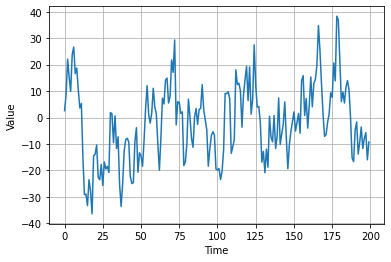

In [14]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

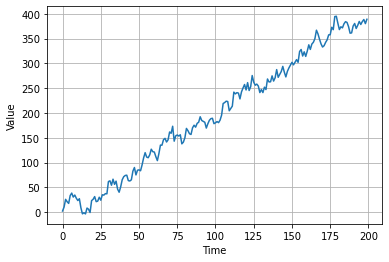

In [15]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2) # 자기 상관에 경향 추가
plot_series(time[:200], series[:200])
plt.show()

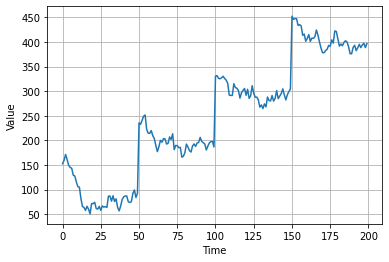

In [16]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

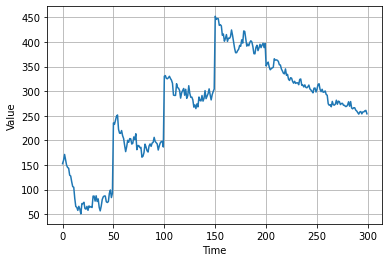

In [18]:
# 급수 구간을 2개 생성 -> 서로 성격이 다른 두개의 그래프로 표현됨
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [20]:
def impulses(time, num_impulses, amplitude=1, seed=None): # 임펄스. 일정 순간에 값이 팍 솟아오르는거
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10) # indices나 index나 의미는 거의 같다. 걍 인덱스의 다른 표현이라고 생각해도 무방할듯 하다. 
    series = np.zeros(len(time)) # 0으로 초기화. 길이는 time만큼
    for index in impulse_indices: # 일정 
        series[index] += rnd.rand() * amplitude
    return series    

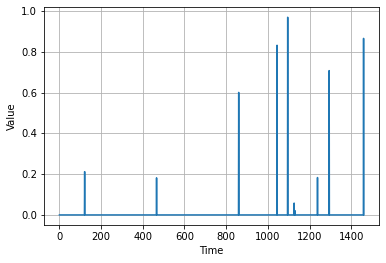

In [21]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [22]:
def autocorrelation(source, φs): # Y값을 받아 새로운 Y값을 생성
    ar = source.copy() # 기존  Y값 받아오기
    max_lag = len(φs)
    for step, value in enumerate(source): # enumerate() : 순서가 있는 자료형(리스트 등)을 입력으로 받아 인덱스 값을 포함하는 enumerate객체로 리턴
        # print(step) # x값
        # print(value) # y값
        for lag, φ in φs.items(): # items : 키, 값 뽑아내기 {1:0.8}이면 1은 lag, 0.8은 φ다. {키 : 값}이 한 세트밖에 없을 때는 한 번만 연산하고 지나간다. 
            # {1: 0.70, 50: 0.2}은 {1:0.7}과 {50:0.2}가 있으니 두 번 실행되고 지나간다. 
            # print(lag)
            # print(φ)
            if step - lag > 0:
              ar[step] += φ * ar[step - lag] # ar[step - lag] : lag만큼 이전 시간대의 y값 -> 이전 시간대의 값 사용
              # 아 그럼 시간이 갈수록 이전 값의 일정 부분을받아 현재 값에 더하는 거니까 임펄스 함수같은 경우는 확 튀고난 뒤에 점점 감소하다가 확 튀고 점점 감소하고 하는구나. 그 추가되는 비중이 바로 φ인거고.
              # {1:0.7}과 {50:0.2}인 경우 우선 직전 타임의 y값을 70% 반영하고 50타임 이전의 값을 20% 반영한다. 그래서 임펄스 이후 값이 상승하는 경우가 있던 것
    return ar

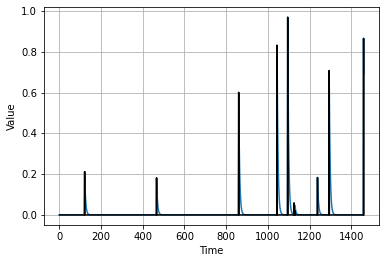

In [23]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.8}) # 1 옆에 있는 숫자가 1에 가까워질수록 그래프에서 임펄스  사이에 존재하는 하강 곡선이 더 크게 생긴다. 
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

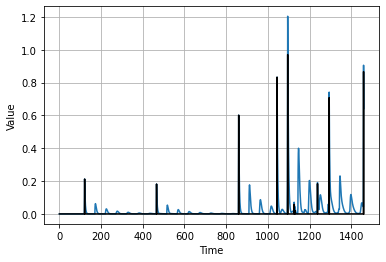

In [24]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

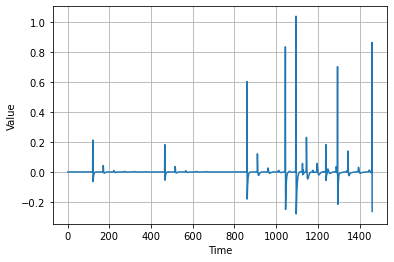

In [25]:
series_diff1 = series[1:] - series[:-1] # (두번째부터 마지막까지) - (처음부터 뒤에서 두번재까지)
plot_series(time[1:], series_diff1)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

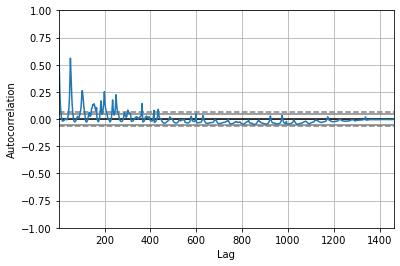

In [26]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [27]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Sat, 23 Jan 2021   AIC                          -4432.855
Time:                        09:07:35   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

In [29]:
import pandas as pd

df = pd.read_csv("sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

FileNotFoundError: [Errno 2] No such file or directory: 'sunspots.csv'

In [ ]:
series.plot(figsize=(12, 5))

In [ ]:
series["1995-01-01":].plot()

In [ ]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [ ]:
autocorrelation_plot(series.diff(1)[1:])

In [ ]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

In [ ]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [ ]:
116.7 - 104.3

In [ ]:
[series.autocorr(lag) for lag in range(1, 50)]

In [ ]:
pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
Read a comma-separated values (csv) file into DataFrame.


In [ ]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

In [ ]:
import pandas as pd

series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()